In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 9.5 MB/s eta 0:00:00


Подключим gdrive

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Импортируем необходимые библиотеки

In [3]:
import yaml
from zipfile import ZipFile
import os
import shutil
import pandas as pd
from os import listdir
from ultralytics import YOLO
import cv2
from sklearn.model_selection import train_test_split
from random import sample
from google.colab.patches import cv2_imshow

Подгружаем данные

In [4]:
!cp /content/drive/MyDrive/data/car_object_detection.zip .
!cp /content/drive/MyDrive/yolo_config.yaml .

file_name = "car_object_detection.zip"
with ZipFile(file_name, 'r') as zip:

    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

!ls

Extracting all the files now...
Done!
car_object_detection.zip  data	drive  sample_data  yolo_config.yaml


Данные уже разбиты на обучающий и тестовый наборы. Для тестового набора разметка отсутствует. Для обучения модели необходимо выделить валидационный набор из тестового.

Разбросаем изображения и разметку к ним по папкам соответствующим образом

In [5]:
train_path_img_orig = "./data/training_images/"
train_path_img = "./data/images/train/"
train_path_label = "./data/labels/train/"
val_path_img = "./data/images/val/"
val_path_label = "./data/labels/val/"
test_path_img = "./data/testing_images/"

In [6]:
from scipy.sparse import random
# train -> train и val
train_img_names, val_img_names = train_test_split(list(listdir(train_path_img_orig)), test_size=0.2, random_state=12)

In [7]:
# создаем необходимые дирректории
os.makedirs(train_path_img, exist_ok=True)
os.makedirs(train_path_label, exist_ok=True)
os.makedirs(val_path_img, exist_ok=True)
os.makedirs(val_path_label, exist_ok=True)

In [8]:
# перемещаем в них файлы
def copy_(in_dir: str, out_dir: str, img_names: list[str]) -> None:
  for img_name in img_names:
    shutil.copy(in_dir + img_name, out_dir)

In [9]:
copy_(train_path_img_orig, train_path_img, train_img_names)
copy_(train_path_img_orig, val_path_img, val_img_names)
shutil.rmtree(train_path_img_orig)

In [10]:
# загрузим имеющуюся разметку хмммм на изображении может и не быть машин, проверим что число
# изображений совпадает с кол-ом строк в датафрейме с разметкой
df = pd.read_csv("./data/train_solution_bounding_boxes (1).csv")
df.sample(3)

,image,xmin,ymin,xmax,ymax
341,vid_4_26460.jpg,473.493488,185.567889,573.279305,227.138031
530,vid_4_9580.jpg,32.987618,199.798413,105.855790,228.839864
326,vid_4_26440.jpg,480.341534,182.633526,563.007236,214.911519


In [11]:
# assert (len(listdir(train_path_img)) + len(listdir(val_path_img))) == len(df), "Изображения, на которых нет машины, пропущены в датафрейме"

if (len(listdir(train_path_img)) + len(listdir(val_path_img))) != len(df):
  print("Изображения, на которых нет машины, пропущены в датафрейме")

Изображения, на которых нет машины, пропущены в датафрейме


В ultralytics для избражений, где нет объектов, файлы разметки не нужны

In [12]:
# функция для преобразования координат объекта в yolo формат(x_центр, y_центр, ширина, высота)
def to_yolo(xmin, ymin, xmax, ymax):
  width = int(xmax - xmin)
  height = int(ymax - ymin)
  x_center = int(xmin + width / 2)
  y_center = int(ymin + height / 2)
  return (x_center, y_center, width, height)


# функция для генерации файлов разметки
# надо не забыть нормализовать координаты
def get_label_txt(in_dir, out_dir, df):
  for img_name in listdir(in_dir):
    if img_name in df.image.values:
      with open(out_dir + img_name.split(".")[0] + ".txt", "w") as f:
        curr_data = df[df.image == img_name]
        xmin, ymin, xmax, ymax = curr_data.xmin.values[0], curr_data.ymin.values[0], curr_data.xmax.values[0], curr_data.ymax.values[0]
        x_center, y_center, width, height = to_yolo(xmin, ymin, xmax, ymax)
        curr_img = cv2.imread(in_dir + img_name)
        img_height, img_width, _ = curr_img.shape

        x_center = round(float(x_center) / img_width, 2)
        y_center = round(float(y_center) / img_height, 2)
        width = round(float(width) / img_width, 2)
        height = round(float(height) / img_height, 2)

        # в начало добавляем id класса
        res_str = "0 " + " ".join(list(map(str, [x_center, y_center, width, height])))
        f.write(res_str)

In [13]:
# сгенерируем файлы разметки
get_label_txt(train_path_img, train_path_label, df)
get_label_txt(val_path_img, val_path_label, df)

Перед обучением модели необходимо подготовить конфигурационный файл(уже есть)

In [14]:
!cat yolo_config.yaml

train: /content/data/images/train
val: /content/data/images/val

nc: 1
names: [
  "car"
]

Запустим обучение модели

In [15]:
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 89.8MB/s]


In [16]:
model.train(
    data="yolo_config.yaml",
    epochs=25,
    project="/content/drive/MyDrive/ultralytics_logs/",
    name="yolov8s_cars"
    )

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=yolo_config.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/ultralytics_logs/, name=yolov8s_cars, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, form

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bad93137d30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Обработка изображений из тестового набора с использованием обученных весов

In [17]:
model = YOLO("/content/drive/MyDrive/ultralytics_logs/yolov8s_cars/weights/best.pt")
model.predict("./data/testing_images", save=True, project="/content/drive/MyDrive/ultralytics_logs/", name="inference_yolov8s_cars")


image 1/175 /content/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 72.4ms
image 2/175 /content/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 11.0ms
image 3/175 /content/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 11.0ms
image 4/175 /content/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 11.0ms
image 5/175 /content/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 12.9ms
image 6/175 /content/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 11.0ms
image 7/175 /content/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 11.5ms
image 8/175 /content/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 11.0ms
image 9/175 /content/data/testing_images/vid_5_25260.jpg: 384x640 (no detections), 11.1ms
image 10/175 /content/data/testing_images/vid_5_26320.jpg: 384x640 (no detections), 11.0ms
image 11/175 /content/data/testing_images/vid_5_26400.jpg: 384x640 (no detections), 11.0ms
image 1

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'car'}
 orig_img: array([[[254, 222, 187],
         [254, 222, 187],
         [251, 221, 186],
         ...,
         [239, 188, 138],
         [238, 187, 137],
         [238, 187, 137]],
 
        [[255, 223, 188],
         [255, 223, 188],
         [253, 223, 188],
         ...,
         [239, 188, 138],
         [239, 188, 138],
         [239, 188, 138]],
 
        [[254, 224, 189],
         [254, 224, 189],
         [254, 224, 189],
         ...,
         [239, 188, 138],
         [239, 188, 138],
         [240, 189, 139]],
 
        ...,
 
        [[ 57,  46,  38],
         [ 59,  48,  40],
         [ 60,  47,  39],
         ...,
         [ 38,  76, 100],
         [ 38,  75, 101],
         [ 38,  76, 100]],
 
        [[ 58,  44,  38],
         [ 59,  45,  39],
         [ 59,  45,  39],
         ...,
         [ 40,  77,  99],
      

Посмотрим на случайное изображение

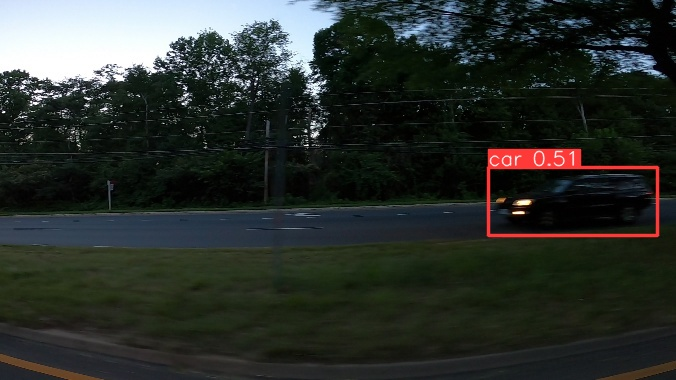

In [36]:
infer_imgs_dir_path = "./drive/MyDrive/ultralytics_logs/inference_yolov8s_cars/"
curr_img_name = sample(listdir(infer_imgs_dir_path), 1)
curr_img = cv2.imread(infer_imgs_dir_path + curr_img_name[0])
cv2_imshow(curr_img)